This is to follow https://www.youtube.com/watch?v=VMj-3S1tku0

In [98]:
import math
import numpy as np 
import matplotlib.pyplot as plt
from graphviz import Digraph
import random

Micrograd from scratch

In [99]:
class Value:

    def __init__(self, data, _children=(), _op='',):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def pow(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):  # self ** other
        return self.pow(other)

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    

    

Create the nerual net

In [100]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

visualization

In [101]:
# Imported from the github repo
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Value(data=1215, grad=0.0)
{Value(data=5, grad=0.0), Value(data=1210, grad=0.0)}
+


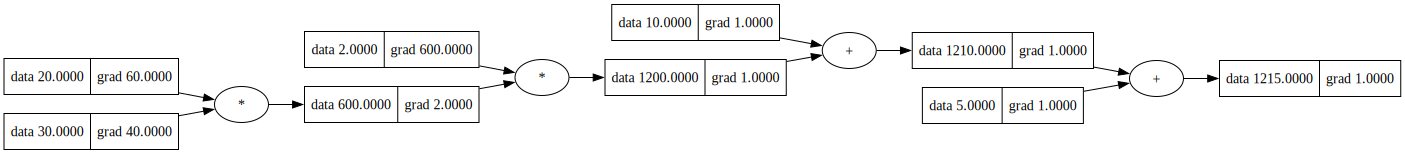

In [102]:
# Example of backprop
a = Value(10,)
b = Value(20)
c = Value(30)
d = Value(5)
e = Value(2)
f = a + b * c * e + d
print(f)
print(f._prev)
print(f._op)

f.backward()

draw_dot(f)

In [103]:
n = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.3464046992407725, grad=0.0),
 Value(data=-0.589820249051437, grad=0.0),
 Value(data=0.3930648401961541, grad=0.0),
 Value(data=0.16337197589299404, grad=0.0)]

In [104]:
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, y_pred))
loss

Value(data=3.2360103449746993, grad=0.0)

In [105]:
for k in range(20):
    # Forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, y_pred))
    
    # Backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    # Update weights
    for p in n.parameters():
        p.data += -0.01 * p.grad

    # Print loss
    print(k, loss.data)
    

0 3.2360103449746993
1 2.789773636292947
2 2.3990216533838224
3 2.0345248717703153
4 1.7064874321439094
5 1.426848773431499
6 1.1968676054729412
7 1.0107256288461222
8 0.860776579342357
9 0.7398423278742874
10 0.6418506933891286
11 0.5619029995252027
12 0.49614825946814584
13 0.44159969413425915
14 0.395952937348903
15 0.3574297482562893
16 0.3246528188317117
17 0.2965491857458176
18 0.2722771376119276
19 0.2511713748817248


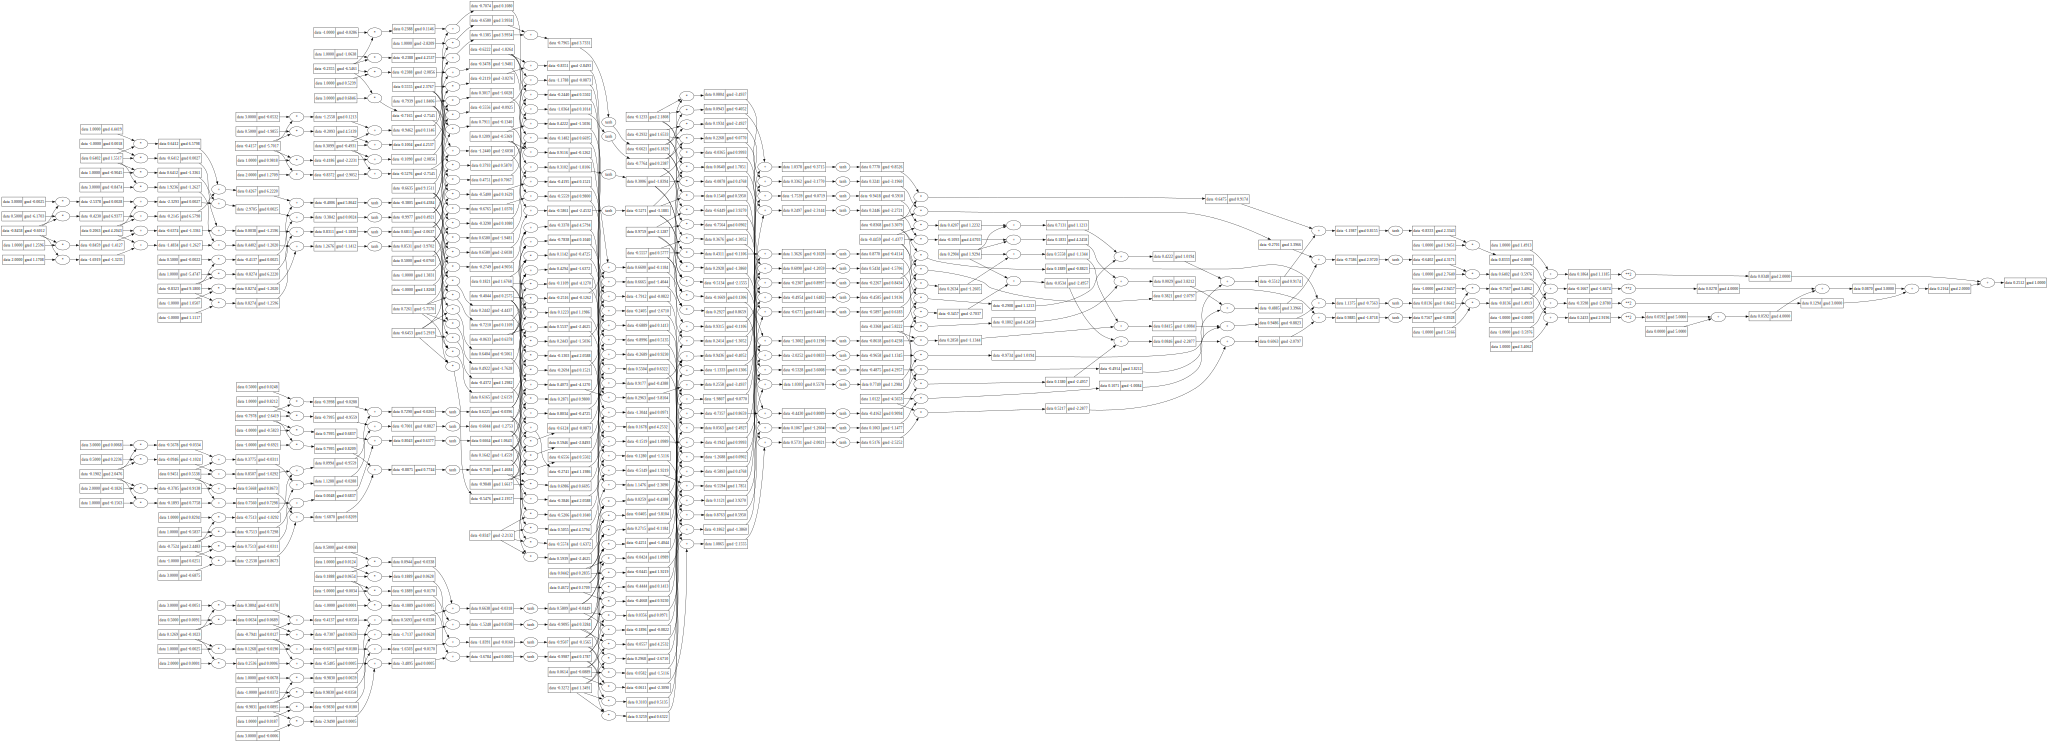

In [106]:
# For visualization

loss.backward()
draw_dot(loss)